In [1]:
import os

import pandas as pd
import numpy as np

import time

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, FMClassifier
from pyspark.ml import PipelineModel
from sim4rec.modules import Simulator

from replay.metrics import NDCG, Precision, RocAuc, Metric
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
from IPython.display import clear_output

from sim4rec.utils import VectorElementExtractor
from sim4rec.modules import RealDataGenerator, SDVDataGenerator
from sim4rec.modules import EvaluateMetrics
from sim4rec.response import ParametricResponseFunction, BernoulliResponse

from replay.models import UCB, ThompsonSampling
from replay.models import RandomRec
from replay.splitters import RandomSplitter

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[*]')\
    .config('spark.sql.shuffle.partitions', '192')\
    .config('spark.default.parallelism', '192')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '256g')\
    .config('spark.driver.maxResultSize', '256g')\
    .getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

def calc_metric(response_df):
    return response_df.groupBy("user_idx").agg(sf.sum("response").alias("num_positive")).select(sf.mean("num_positive")).collect()[0][0]

24/05/26 22:08:00 WARN Utils: Your hostname, ecs-syudosaev-big resolves to a loopback address: 127.0.1.1; using 10.11.12.124 instead (on interface eth0)
24/05/26 22:08:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/05/26 22:08:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
song_attrs = spark.read.csv('song_attributes.csv', header=True, inferSchema=True)

In [3]:
train_df = spark.read.parquet('train_trim.parquet')
test_df = spark.read.parquet('test_trim.parquet')

item_svd = spark.read.parquet('item_svd.parquet').limit(2000)
user_svd = spark.read.parquet('user_svd.parquet').limit(6000)

train_df = train_df.join(item_svd, on='song_id', how='inner')
train_df = train_df.join(user_svd, on='user_id', how='inner')

test_df = test_df.join(item_svd, on='song_id', how='inner')
test_df = test_df.join(user_svd, on='user_id', how='inner')

avg_item_ratings = train_df.select('song_id', 'rating').groupBy('song_id').agg(sf.mean("rating").alias('item_rating_avg'))
train_df = train_df.join(avg_item_ratings, on='song_id', how='inner')
test_df = test_df.join(avg_item_ratings, on='song_id', how='inner')

train_df = train_df.withColumn('relevance', sf.when(sf.col('rating') >= 3, 1).otherwise(0))
test_df = test_df.withColumn('relevance', sf.when(sf.col('rating') >= 3, 1).otherwise(0))

In [4]:
items = item_svd.join(song_attrs, on='song_id', how='inner')
funcs = [f'iembed_{i}' for i in range(128)]
artist_embeds = items.groupby('artist_id').agg(*[sf.mean(emb).alias('a_' + emb) for emb in funcs])

train_df = train_df.join(song_attrs, on='song_id', how='inner')
train_df = train_df.join(artist_embeds, on='artist_id', how='inner')
train_df = train_df.withColumnRenamed('user_id', 'user_idx').withColumnRenamed('song_id', 'item_idx').cache()
test_df = test_df.join(song_attrs, on='song_id', how='inner')
test_df = test_df.join(artist_embeds, on='artist_id', how='inner')

In [5]:
va = VectorAssembler(
    inputCols=item_svd.columns[:-1] + user_svd.columns[:-1],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)
fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)
lr_model = lr.fit(va.transform(train_df))
rf_model = rf.fit(va.transform(train_df))
fm_model = fm.fit(va.transform(train_df))

vee = VectorElementExtractor(inputCol='proba', outputCol='scores', index=1)
mc = ParametricResponseFunction(inputCols=['scores'], outputCol='__pr', weights=[0.25])
br = BernoulliResponse(inputCol='__pr', outputCol='response', seed=1234)
pipeline_lr = PipelineModel(stages=[va, lr_model, vee, mc, br])
pipeline_rf = PipelineModel(stages=[va, rf_model, vee, mc, br])
pipeline_fm = PipelineModel(stages=[va, fm_model, vee, mc, br])

In [6]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

def get_baseline(pred_df):
    pred_df = pred_df.select('item_rating_avg', 'relevance').toPandas()
    pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
    pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0) 
    print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")
    print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")
    print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")
    print(f"Accuracy (baseline): {accuracy_score(pred_df.relevance, pred_df.baseline_bin)}")
    print()

def assess_models(model, test_df):
    pred_df = model.transform(test_df).select("relevance", "scores").toPandas()
    pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)
    print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
    print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"Accuracy (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")
    print()

get_baseline(test_df)
assess_models(pipeline_lr, test_df)
assess_models(pipeline_rf, test_df)
assess_models(pipeline_fm, test_df)

# 0.7355

ROC AUC (baseline): 0.6314382862141088
Precision (baseline): 0.6321177223288548
Recall (baseline): 0.8715083798882681
Accuracy (baseline): 0.626210235131397



ROC AUC (classificator): 0.7497673847007305
Precision (classificator): 0.7033662363958492
Recall (classificator): 0.8171126139370773
Accuracy (classificator): 0.6898340248962656



ROC AUC (classificator): 0.7042128509264449
Precision (classificator): 0.6343414634146342
Recall (classificator): 0.9558953249044398
Accuracy (classificator): 0.6500691562932227



ROC AUC (classificator): 0.7605715186086687
Precision (classificator): 0.6729411764705883
Recall (classificator): 0.9250220523375478
Accuracy (classificator): 0.6915629322268326



In [7]:
ts_lr = ThompsonSampling(sample = True)
ts_lr.fit(log=train_df.drop('response').limit(1))

ts_rf = ThompsonSampling(sample = True)
ts_rf.fit(log=train_df.drop('response').limit(1))

ts_fm = ThompsonSampling(sample = True)
ts_fm.fit(log=train_df.drop('response').limit(1))

random_uni = RandomRec(distribution="uniform")
random_uni.fit(log=train_df.drop('response').limit(1))

In [14]:
evaluator = EvaluateMetrics(
    userKeyCol='user_idx',
    itemKeyCol='item_idx',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10, Precision() : 10, RocAuc(): 10}
)

users_df = user_svd.withColumnRenamed('user_id', 'user_idx').cache()
items_df = item_svd.withColumnRenamed('song_id', 'item_idx').cache()

users_generator = RealDataGenerator(label='users_real', seed=1234)
items_generator = RealDataGenerator(label='items_real', seed=1234)
users_generator.fit(users_df)
items_generator.fit(items_df)
_ = users_generator.generate(users_df.count())

In [15]:
def do_a_cycle(simul, model, pipeline, iteration, metrics):
    users = simul.sample_users(1.0).cache()
    log = simul.get_log(user_df=users)
    log = train_df.drop('response').limit(1) if log is None else log

    item_ids = items_df.select("item_idx").sample(0.2).cache()
    recs = model.predict(
        log,
        k=10,
        users=users.select("user_idx"),
        items=item_ids,
        filter_seen_items = False
    )
    resp = simul.sample_responses(
        recs_df=recs, 
        user_features=users,
        item_features=items_df,
        action_models=pipeline,
    ).select('user_idx', 'item_idx', 'relevance', 'response').cache()
    simul.update_log(resp, iteration=iteration)
    met = calc_metric(resp)
    ev = evaluator(resp)
    ev['CR'] = met
    metrics.append(ev)

    model._clear_cache()
    train_log = simul.log.cache()
    model.fit(train_log.select('user_idx', 'item_idx', 'response').withColumnRenamed('response', 'relevance'))

    log.unpersist()
    users.unpersist()
    recs.unpersist()
    resp.unpersist()
    train_log.unpersist()

sim_lr = Simulator(users_generator, items_generator, f'checkpoints/lr', None, 'user_idx', 'item_idx', spark)
sim_rf = Simulator(users_generator, items_generator, f'checkpoints/rf', None, 'user_idx', 'item_idx', spark)
sim_fm = Simulator(users_generator, items_generator, f'checkpoints/fm', None, 'user_idx', 'item_idx', spark)
sim_rand = Simulator(users_generator, items_generator, f'checkpoints/rand', None, 'user_idx', 'item_idx', spark)

lr_metrics = []
rf_metrics = []
fm_metrics = []
rnd_metrics = []

for i in range(50):
    print(f'------------------------Stage {i}------------------------')
    start_iter = time.time()

    do_a_cycle(sim_lr, ts_lr, pipeline_lr, i, lr_metrics)
    do_a_cycle(sim_rf, ts_rf, pipeline_rf, i, rf_metrics)
    do_a_cycle(sim_fm, ts_fm, pipeline_fm, i, fm_metrics)
    do_a_cycle(sim_rand, random_uni, pipeline_lr, i, rnd_metrics)
    # plot_metric(lr_metrics)
    clear_output(wait=True)
    end_iter = time.time()
    print(f"Time of {i+1} iteration: ")
    print(end_iter - start_iter)

Time of 50 iteration: 
82.63243651390076


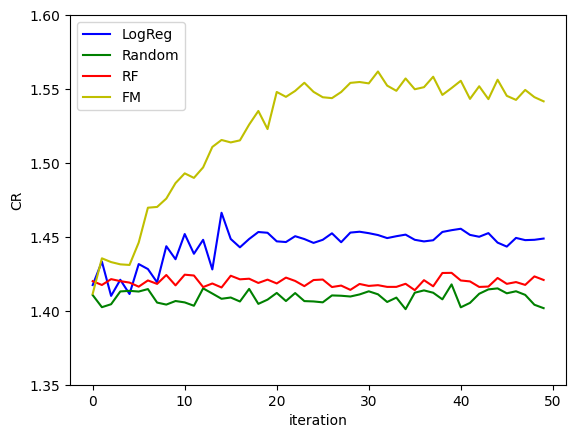

In [23]:
metrics_lr = pd.DataFrame(lr_metrics)
metrics_rnd = pd.DataFrame(rnd_metrics)
metrics_rf = pd.DataFrame(rf_metrics)
metrics_fm = pd.DataFrame(fm_metrics)

plt.plot(metrics_lr['CR'], color='b')
plt.plot(metrics_rnd['CR'], color='g')
plt.plot(metrics_rf['CR'], color='r')
plt.plot(metrics_fm['CR'], color='y')
plt.xlabel('iteration')
plt.ylabel('CR')
plt.ylim(1.35, 1.6)
plt.savefig('ml_ndcg_new_users_base.png', dpi=300)